In [ ]:
path = '/content/drive/MyDrive/Datasets'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Datasets'

/content/drive/MyDrive/Datasets


In [ ]:
%pwd

'/content/drive/MyDrive/Datasets'

In [ ]:
# importing modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from keras.utils import pad_sequences
from keras.losses import BinaryFocalCrossentropy, BinaryCrossentropy
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
imbalance_data = pd.read_csv('imbalanced_data.csv')

In [ ]:
imbalance_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Only the label and tweet columns are suitable for the prediction.

    0: not hate speech
    1: it's a hate speech

<Axes: xlabel='label', ylabel='count'>

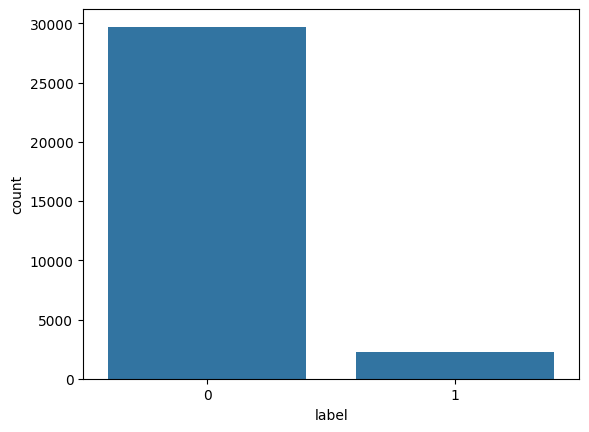

In [ ]:
sns.countplot(x='label', data=imbalance_data)

This data is imbalanced. Hence, concatenating the raw data which has hate speech examples with the imabalanced data.  

In [ ]:
imbalance_data.shape

(31962, 3)

In [ ]:
imbalance_data.isnull().sum()

,0
id,0
label,0
tweet,0


In [ ]:
# dropping id col
imbalance_data.drop('id', axis=1, inplace=True)

In [ ]:
imbalance_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
raw_data = pd.read_csv('raw_data.csv')

In [ ]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Only need 'tweet' and 'class' columns from the above dataset

In [ ]:
raw_data.shape

(24783, 7)

In [ ]:
raw_data.isnull().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [ ]:
raw_data.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1, inplace=True)

In [ ]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
raw_data['class'].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

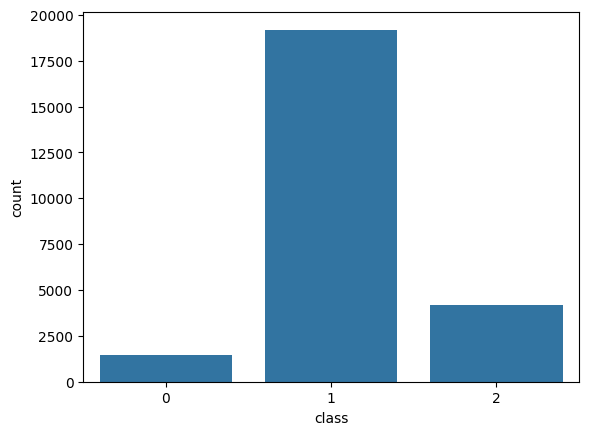

In [ ]:
sns.countplot(x='class', data=raw_data)

- class 0 : hate
- class 1 : abusive
- class 2 : no hate

Abusive and hate are of similar category, converting this data into 2 categories hate and no hate

For the previous dataset
- 0: no hate
- 1: hate

For this data need to convert
- 2 -> 0 (no hate)
- 0 -> 1 (hate)

In [ ]:
## replace 0 -> 1
raw_data['class'].replace({0:1}, inplace=True)

In [ ]:
raw_data['class'].unique()

array([2, 1])

In [ ]:
## replace 2 -> 0
raw_data['class'].replace({2:0}, inplace=True)

In [ ]:
raw_data['class'].unique()

array([0, 1])

<Axes: xlabel='class', ylabel='count'>

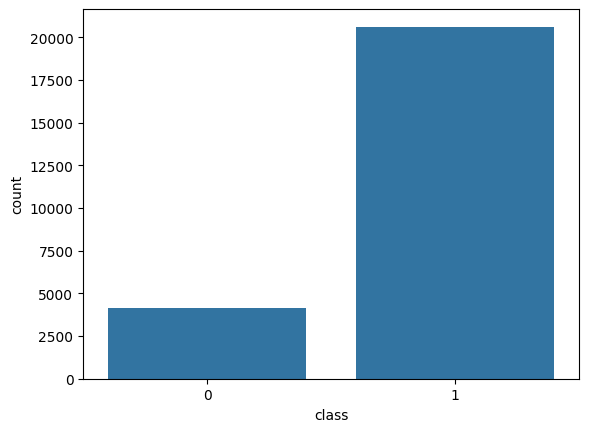

In [ ]:
sns.countplot(x='class', data=raw_data)

In [ ]:
## renaming the column name
raw_data.rename(columns={'class':'label'}, inplace=True)

In [ ]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
## performing the concatenation operation
frame = [imbalance_data, raw_data]
df = pd.concat(frame)

In [ ]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
df.shape

(56745, 2)

<Axes: xlabel='label', ylabel='count'>

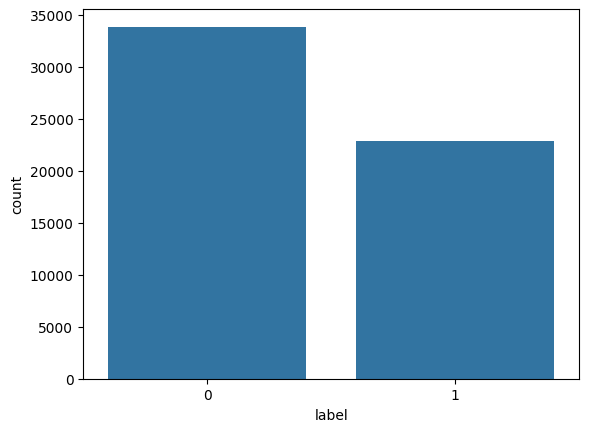

In [ ]:
sns.countplot(x='label', data=df)

Handled the missing data scenario

In [ ]:
## apply stemming and stopwords on the data
## performing dimensionality reduction by converting words to its root form
stemmer = nltk.SnowballStemmer('english')

## stopwords are not needed for this classification problem
## we don't need all the words to classify whether it's a positive or negative
stopword = set(stopwords.words('english'))

In [ ]:
import string

In [ ]:
## applying regx and perform cleaning
def data_clean(words):
  words = str(words).lower()
  words = re.sub('\[.*?\]', '', words)
  words = re.sub('https?://\S+|www\.\S+', '', words)
  words = re.sub('<.*?>+', '', words)
  words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
  words = re.sub('\n', '', words)
  words = re.sub('\w*\d\w*', '', words)
  words = [word for word in words.split(' ') if words not in stopword]
  words = " ".join(words)
  words = [stemmer.stem(words) for word in words.split(' ')]
  words = " ".join(words)

  return words

In [ ]:
## applying the function onto the dataset
df['tweet'] = df['tweet'].apply(data_clean)

In [ ]:
df['tweet'][1]

,tweet
1,user user thanks for lyft credit i cant use ca...
1,rt boy dats coldtyga dwn bad for cuffin dat ...


In [ ]:
df.head()

,label,tweet
0,0,user when a father is dysfunctional and is so...
1,0,user user thanks for lyft credit i cant use ca...
2,0,bihday your majesti bihday your majesti ...
3,0,model i love u take with u all the time in u...
4,0,factsguide society now motiv factsguide s...


In [ ]:
x = df['tweet']
y = df['label']

In [ ]:
x_train_strat, x_test_strat, y_train_strat, y_test_strat = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Second split without stratification
x_train_nostrat, x_test_nostrat, y_train_nostrat, y_test_nostrat = train_test_split(x, y, test_size=0.2, random_state=42)

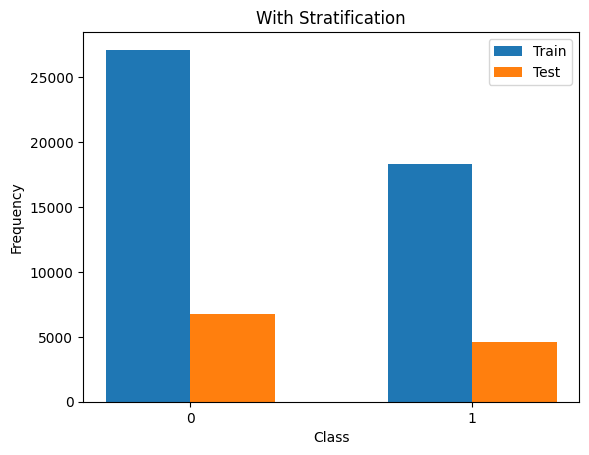

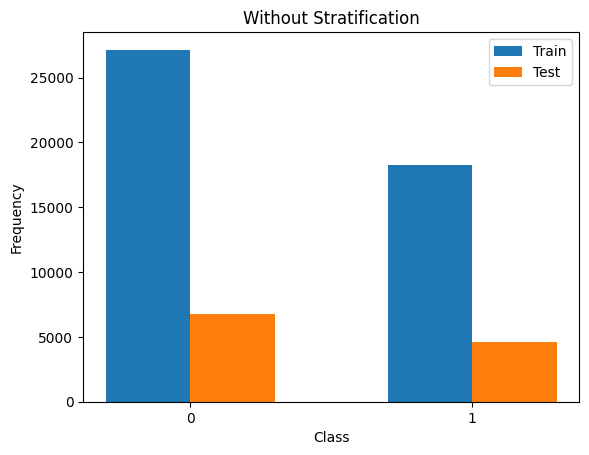

In [ ]:
# Function to plot class distributions
def plot_class_distribution(y_train, y_test, title):
    train_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)

    labels = np.arange(len(train_counts))

    width = 0.3  # width of bars

    fig, ax = plt.subplots()
    ax.bar(labels - width/2, train_counts, width, label='Train')
    ax.bar(labels + width/2, test_counts, width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks(labels)
    ax.legend()

    plt.show()

# Plot with stratification
plot_class_distribution(y_train_strat, y_test_strat, "With Stratification")

# Plot without stratification
plot_class_distribution(y_train_nostrat, y_test_nostrat, "Without Stratification")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

45396 45396
11349 11349


In [ ]:
max_words = 1000 # 50000   ## total words
max_len = 100 #300       ## max length of a sentence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

In [ ]:
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# integer encoding, assigned number to a unique word
sequences_matrix

array([[  3, 391,  11, ..., 391,  11,  25],
       [  0,   0,   0, ...,   9,   2,  41],
       [ 64,  13,   1, ...,  13,   1, 858],
       ...,
       [  0,   0,   0, ..., 149, 480, 149],
       [156,  12, 147, ...,  72,   1, 156],
       [  0,   0,   0, ...,  72,  59,  17]], dtype=int32)

In [ ]:
print(sequences_matrix[0].shape)
print(sequences_matrix[3].shape)

(100,)
(100,)


In [ ]:
## Create model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))  ## convert data to vector: 1 word in 100-D space
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Build the model with specified input shape
model.build(input_shape=(None, max_len))

# Compile the model
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,501 (705.08 KB)

 Trainable params: 180,501 (705.08 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 58s 206ms/step - accuracy: 0.9338 - loss: 0.1850 - val_accuracy: 0.9249 - val_loss: 0.2017
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 81s 204ms/step - accuracy: 0.9348 - loss: 0.1862 - val_accuracy: 0.9259 - val_loss: 0.1993
Epoch 3/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.9331 - loss: 0.1827 - val_accuracy: 0.9258 - val_loss: 0.2013
Epoch 4/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9343 - loss: 0.1811 - val_accuracy: 0.9252 - val_loss: 0.2008
Epoch 5/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9346 - loss: 0.1788 - val_accuracy: 0.9251 - val_loss: 0.2008
Epoch 6/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9337 - loss: 0.1781 - val_accuracy: 0.9253 - val_loss: 0.2000
Epoch 7/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9334 - loss: 0.1798 - val_accuracy: 0.9257 - val_loss: 0.2000
Epoch 8/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9345 - loss: 0

In [49]:
x_test

,tweet
14580,last year this little girl had malaria and thi...
13959,haford buffalo simulation buffalo for you to...
11619,old guy off to get some sleep be safe amp be...
15202,rt flexfoee if he fuck yo bitch u should be h...
14284,rt honestyhour no bitch better try to fuck wi...
...,...
24397,running the game for years guess thats why my...
6061,waking up from a dream and having to face real...
1611,fuck a bad bitch id rather have a good girl w...
6860,prettymofocka im outside where you at and im t...


In [50]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [51]:
len(test_sequences_matrix[0])

100

In [52]:
## model evaluation
accr = model.evaluate(test_sequences_matrix, y_test)

355/355 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9273 - loss: 0.2061


In [54]:
print("Test Accuracy:", accr[1])

Test Accuracy: 0.9236056208610535


In [55]:
lstm_pred = model.predict(test_sequences_matrix)

355/355 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step


In [56]:
lstm_pred

array([[2.81675020e-04],
       [8.07287404e-04],
       [1.98421001e-01],
       ...,
       [9.96030271e-01],
       [9.98194873e-01],
       [1.00859225e-01]], dtype=float32)

In [57]:
res = []
for prediction in lstm_pred:
  if prediction[0] < 0.5:
    res.append(0)
  else:
    res.append(1)

In [ ]:
res

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


In [58]:
## calculating the confusion matrix
cm = confusion_matrix(y_test, res)

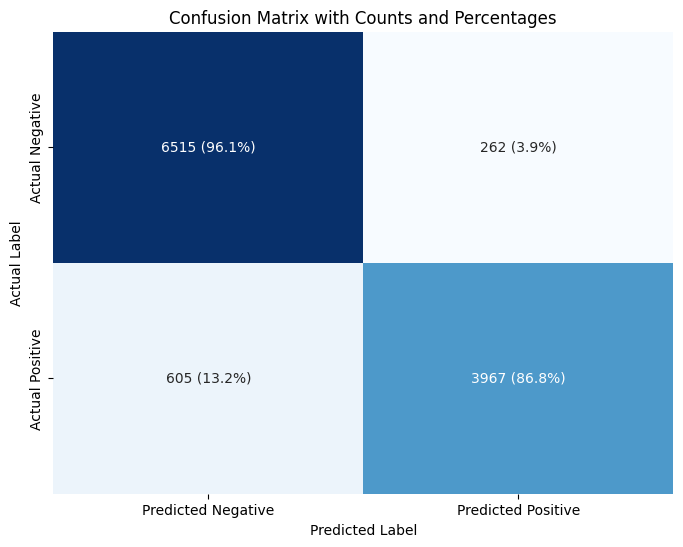

In [61]:
# Flatten the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Create confusion matrix
cm = np.array([[TN, FP],
               [FN, TP]])

# Calculate percentages
cm_sum = cm.sum(axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# Create annotations for each cell
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = f'{c} ({p:.1f}%)'
        elif c == 0:
            annot[i, j] = '0'
        else:
            annot[i, j] = f'{c} ({p:.1f}%)'

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()


In [62]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
## save the model
model.save('hate_speech_model.h5')

In [64]:
import keras

In [65]:
load_model = keras.models.load_model('hate_speech_model.h5')
with open('tokenizer.pickle', 'rb') as handle:
  load_tokenizer = pickle.load(handle)

In [66]:
## testing the model on custom data
test = 'go to hell i will find and kill you dumb'

test = [data_clean(test)]

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
pred = load_model.predict(padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [67]:
print('Probability: ', pred)
if pred < 0.5:
  print('no hate')
else:
  print('hate and abusive')

Probability:  [[0.9126143]]
hate and abusive


In [68]:
test = 'i will not let anyone eat anything and evrything Will be ### racist'
test = [data_clean(test)]

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
pred = load_model.predict(padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


In [69]:
print('Probability: ', pred)
if pred < 0.5:
  print('no hate')
else:
  print('hate and abusive')

Probability:  [[0.545675]]
hate and abusive


In [70]:
test = 'this BURGER is Tasty hmmmmmm !!!!'
test = [data_clean(test)]

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
pred = load_model.predict(padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


In [71]:
print('Probability: ', pred)
if pred < 0.5:
  print('no hate')
else:
  print('hate and abusive')

Probability:  [[0.18555528]]
no hate
